# 4.3 Job Shop Scheduling

Keywords: job shop, scheduling, cbc usage, neos usage, cplex, gdp, disjunctive programming, batch processes

## 4.3.1 Imports

The following cell specifies the solver to used in the subsequent calculations. Some of these problems can become quite larger, and therefore the `gurobi` solver has been set as a default. If you don't have the `gurobi` solver then adjust the code to use the `glpk` solver, but know the calculations may take longer (and the benchmark problem will not solve at all). If you do have the `gurobi` solver, edit the location of the executable to match the location on your computer.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
from pyomo.environ import *
from pyomo.gdp import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.6 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3) ..

## 4.3.2 Background

A job shop consists of a set of distinct machines that process jobs. Each job is a series of tasks that require use of particular machines for known durations, and which must be completed in specified order. The job shop scheduling problem is to schedule the jobs on the machines to minimize the time necessary to process all jobs (i.e, the makespan) or some other metric of productivity. Job shop scheduling is one of the classic problems in Operations Research.

Data consists of two tables. The first table is decomposition of the jobs into a series of tasks. Each task lists a job name, name of the required machine, and task duration. The second table list task pairs where the first task must be completed before the second task can be started. This formulation is quite general, but can also specify situations with no feasible solutions.  

## 4.3.3 Job shop example

The following example of a job shop is from from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Dash Optimization, 2000.

In this example, there are three printed paper products that must pass through color printing presses in a particular order. The given data consists of a flowsheet showing the order in which each job passes through the color presses

![image.png](https://raw.githubusercontent.com/hendrowunga/Mesin_Learning-And-Algoritma-Optimisasi/main/Job%20Shop%20Scheduling/image.png)


and a table of data showing, in minutes, the amount of time each job requires on each machine.

| Machine | Color | Component 1   | Component 2 | Component 3 |
| :-----: | :---: | :-------:     | :-----:     | :---------: |
| 1       | Blue  | 30            | 20          | 20          |
| 2       | Green | -             | 10          | 10          |
| 3       | Yellow| 10            | 39          | 45          |

What is the minimum amount of time (i.e, what is the makespan) for this set of jobs?

## 4.3.4 Task decomposition

The first step in the analysis is to decompose the process into a series of tasks. Each task is a (job,machine) pair. Some tasks cannot start until a prerequisite task is completed.

| Task (Job,Machine)             | Duration | Prerequisite Task      |
| :-----------------------:      | :------: | :---------------:      |
| (Componenet 1, Blue)           | 30       | -                      |
| (Componenet 1, Yellow)         | 10       | (Componenet 1,Blue)    |
| (Componenet 2, Blue)           | 20       | (Componenet 2, Green)  |
| (Componenet 2, Green)          | 10       | -                      |
| (Componenet 2, Yellow)         | 39       | (Componenet 2, Blue)   |
| (Componenet 3, Blue)           | 20       | (Componenet 3, Yellow) |
| (Componenet 3, Green)          | 10       | (Componenet 3, Blue)   |
| (Componenet 3, Yellow)         | 45       | -                      |

We convert this to a JSON style representation where tasks are denoted by (Job,Machine) tuples in Python. The task data is stored in a Python dictionary indexed by (Job,Machine) tuples. The task data conists of a dictionary with duration ('dur') and (Job,Machine) pair for any prerequisite task.

In [19]:
TASKS = {
    ('Component_1', 'Stage_A') : {'dur': 30, 'prec': None},
    ('Component_1', 'Stage_B') : {'dur': 10, 'prec': ('Component_1', 'Stage_A')},
    ('Component_2', 'Stage_A') : {'dur': 20, 'prec': ('Component_2', 'Stage_C')},
    ('Component_2', 'Stage_C') : {'dur': 10, 'prec': None},
    ('Component_2', 'Stage_B') : {'dur': 39, 'prec': ('Component_2', 'Stage_A')},
    ('Component_3', 'Stage_A') : {'dur': 20, 'prec': ('Component_3', 'Stage_B')},
    ('Component_3', 'Stage_C') : {'dur': 10, 'prec': ('Component_3', 'Stage_A')},
    ('Component_3', 'Stage_B') : {'dur': 45, 'prec': None},
}


## 4.3.5 Model formulation

Each task is indexed by an ordered pair $(j,m)$ where $j$ is a job, and $m$ is a machine. Associated with each task is data describing the time needed to perform the task, and a preceeding task that must be completed before the index task can start.

| Parameter | Description |
| :-------- | :-----------|
| $\text{dur}_{j,m}$ | Duration of task $(j,m)$ |
| $\text{prec}_{j,m}$ | A task $(k,n) = \text{prec}_{j,m}$ that must be completed before task $(j,m)$|

The choice of decision variables for this problem are key to modeling. We introduce $makespan$ as the time needed to complete all tasks. $makespan$ is a candidate objective function. Variable $start_{j,m}$ denotes the time when task $(j,m)$ begins.  

| Decision Variables | Description |
| :-------- | :-----------|
| $\text{makespan}$  | Completion of all jobs |
| $\text{start}_{j,m}$ | Start time for task $(j,m)$ |

The constraints include lower bounda on the start and an upper bound on the completion of each task $(j,m)$

\begin{align}
\text{start}_{j,m} & \geq 0\\
\text{start}_{j,m}+\text{dur}_{j,m} & \leq \text{makespan}
\end{align}

Any preceeding tasks must be completed before task $(j,m)$ can start.

\begin{align}
\text{start}_{k,n}+\text{dur}_{k,n}\leq\text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{prec}_{j,m}
\end{align}

Finally, for every task performed on machine $m$, there can be no overlap among those tasks. This leads to a set of pair-wise disjunctive constraints for each machine.

\begin{align}
\left[\text{start}_{j,m}+\text{dur}_{j,m} \leq \text{start}_{k,m}\right] \vee \left[\text{start}_{k,m}+\text{dur}_{k,m} \leq \text{start}_{j,m}\right]
\end{align}

avoids conflicts for use of the same machine.

## 4.3.6 Pyomo implementation

The job shop scheduling problem is implemented below in Pyomo. The implementation consists of of a function JobShopModel(TASKS) that accepts a dictionary of tasks and returns a Pyomo model.

In [20]:
def jobshop_model(TASKS):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])

    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
        model.start[j,m] + model.dur[j,m] <= model.makespan)

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m],
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)
    return model

jobshop_model(TASKS)

In [21]:
def jobshop_solve(model):
    SolverFactory('cbc').solve(model)
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j,m],
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

[{'Job': 'Component_1',
  'Machine': 'Stage_A',
  'Start': 0.0,
  'Duration': 30,
  'Finish': 30.0},
 {'Job': 'Component_1',
  'Machine': 'Stage_B',
  'Start': 45.0,
  'Duration': 10,
  'Finish': 55.0},
 {'Job': 'Component_2',
  'Machine': 'Stage_A',
  'Start': 30.0,
  'Duration': 20,
  'Finish': 50.0},
 {'Job': 'Component_2',
  'Machine': 'Stage_C',
  'Start': 0.0,
  'Duration': 10,
  'Finish': 10.0},
 {'Job': 'Component_2',
  'Machine': 'Stage_B',
  'Start': 55.0,
  'Duration': 39,
  'Finish': 94.0},
 {'Job': 'Component_3',
  'Machine': 'Stage_A',
  'Start': 50.0,
  'Duration': 20,
  'Finish': 70.0},
 {'Job': 'Component_3',
  'Machine': 'Stage_C',
  'Start': 70.0,
  'Duration': 10,
  'Finish': 80.0},
 {'Job': 'Component_3',
  'Machine': 'Stage_B',
  'Start': 0.0,
  'Duration': 45,
  'Finish': 45.0}]

## 4.3.7 Printing schedules

In [22]:
schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
                     Start  Duration  Finish
Job         Machine                         
Component_1 Stage_A    0.0        30    30.0
            Stage_B   45.0        10    55.0
Component_2 Stage_C    0.0        10    10.0
            Stage_A   30.0        20    50.0
            Stage_B   55.0        39    94.0
Component_3 Stage_B    0.0        45    45.0
            Stage_A   50.0        20    70.0
            Stage_C   70.0        10    80.0

Schedule by Machine
                     Start  Duration  Finish
Machine Job                                 
Stage_A Component_1    0.0        30    30.0
        Component_2   30.0        20    50.0
        Component_3   50.0        20    70.0
Stage_B Component_3    0.0        45    45.0
        Component_1   45.0        10    55.0
        Component_2   55.0        39    94.0
Stage_C Component_2    0.0        10    10.0
        Component_3   70.0        10    80.0


## 4.3.8 Visualizing Results with Gantt Charts

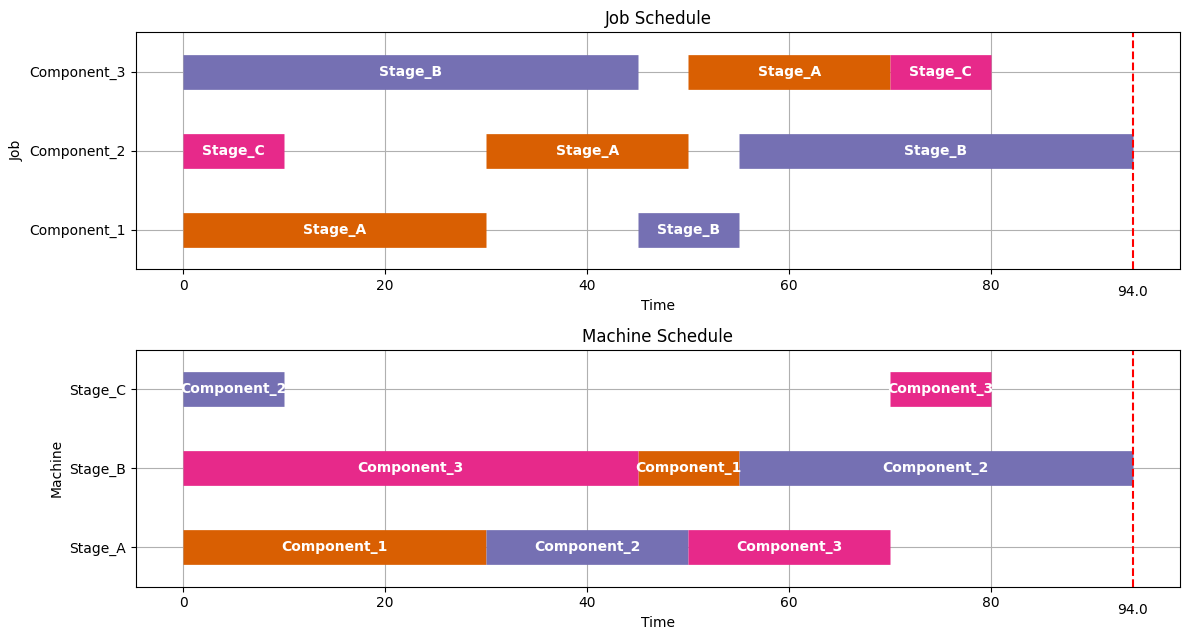

In [23]:
def visualize(results):

    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)

    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    fig.tight_layout()

visualize(results)

## 4.3.9 Application to the scheduling of batch processes

We will now turn our attention to the application of the job shop scheduling problem to the short term scheduling of batch processes. We illustrate these techniques using Example II from Dunn (2013).

![flowshop-Dunn-2013.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/flowshop-Dunn-2013.png?raw=1)

| Recipe  | Mixer | Reactor | Separator | Packaging |
| :-----: | :---: | :-----: | :-------: | :-------: |
| A       | 1.0   | 5.0     | 4.0       | 1.5       |
| B       | -     | -       | 4.5       | 1.0       |
| C       | -     | 3.0     | 5.0       | 1.5       |

### 4.3.9.1 Single product strategies

Before going further, we create a function to streamline the generation of the TASKS dictionary.

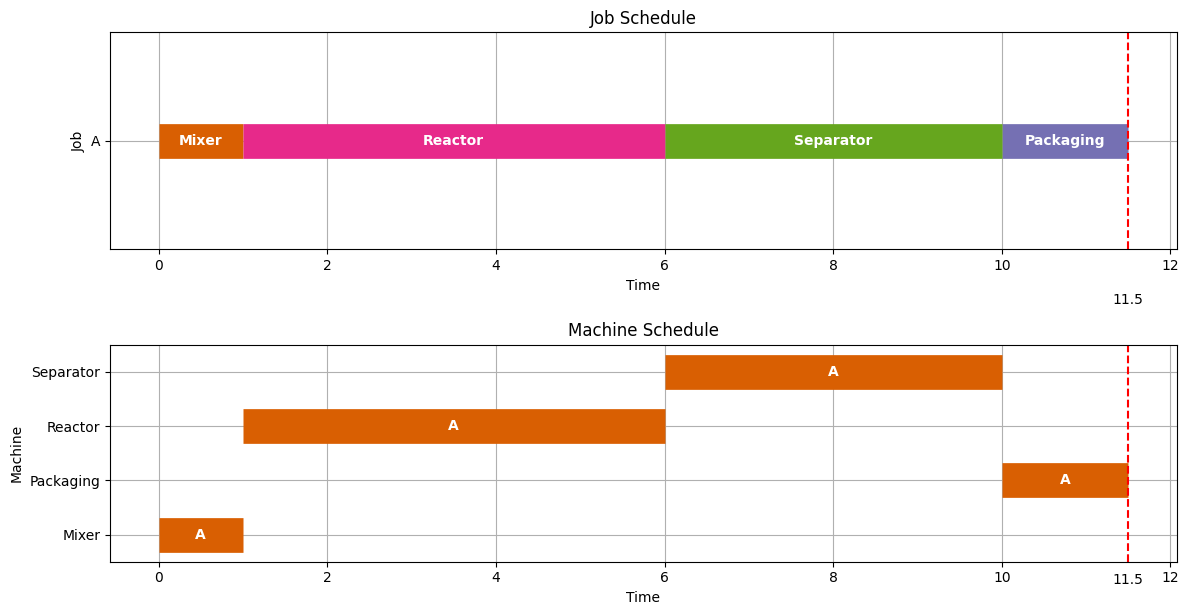

In [24]:
def recipe_to_tasks(jobs, machines, durations):
    TASKS = {}
    for j in jobs:
        prec = (None,None)
        for m,d in zip(machines,durations):
            task = (j,m)
            if prec == (None,None):
                TASKS.update({(j,m): {'dur': d, 'prec': None}})
            else:
                TASKS.update({(j,m): {'dur': d, 'prec': prec}})
            prec = task
    return TASKS

recipeA = recipe_to_tasks('A', ['Mixer', 'Reactor', 'Separator', 'Packaging'], [1, 5, 4, 1.5])
visualize(jobshop(recipeA))

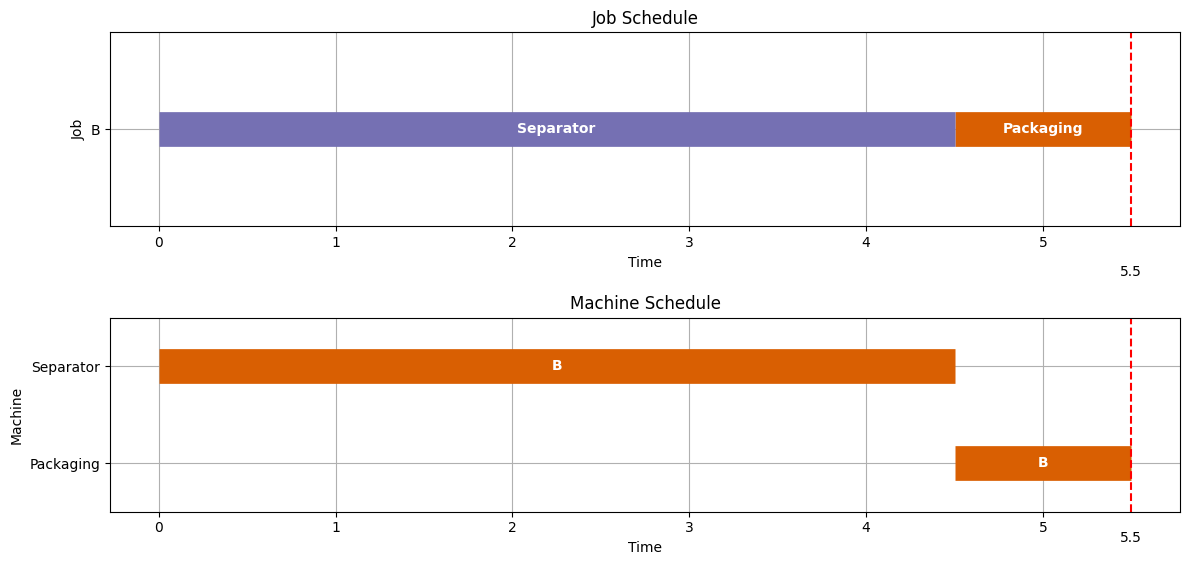

In [25]:
recipeB = recipe_to_tasks('B', ['Separator', 'Packaging'], [4.5, 1])
visualize(jobshop(recipeB))

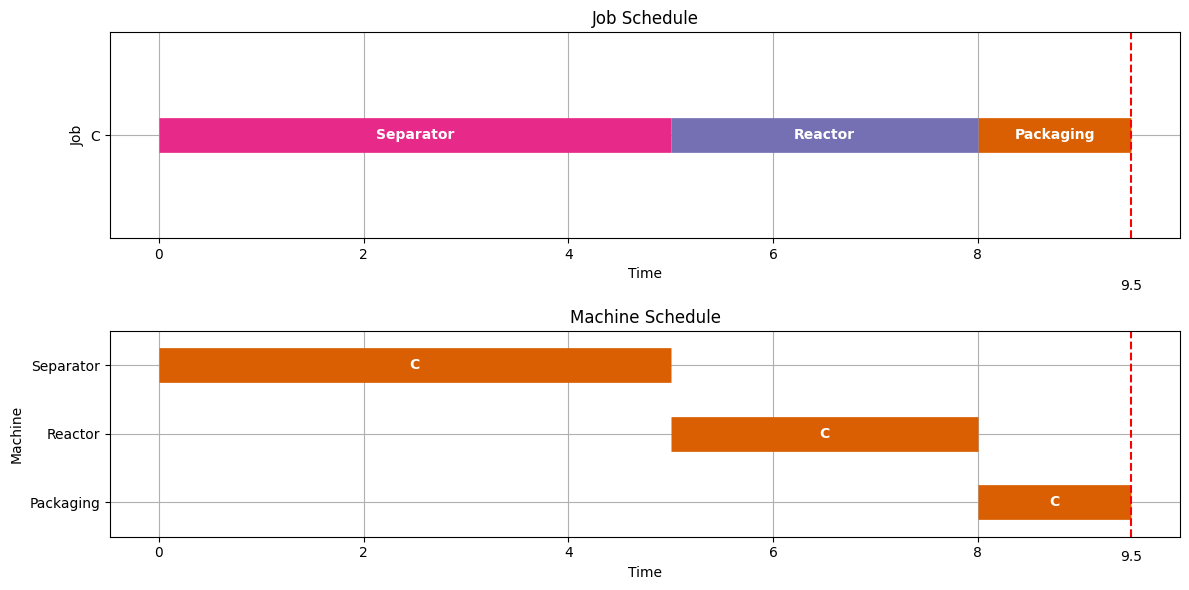

In [26]:
recipeC = recipe_to_tasks('C', ['Separator', 'Reactor', 'Packaging'], [5, 3, 1.5])
visualize(jobshop(recipeC))

### 4.3.9.2 Multiple Overlapping tasks

Let's now consider an optimal scheduling problem where we are wish to make two batches of Product A.

Makespan = 26.5


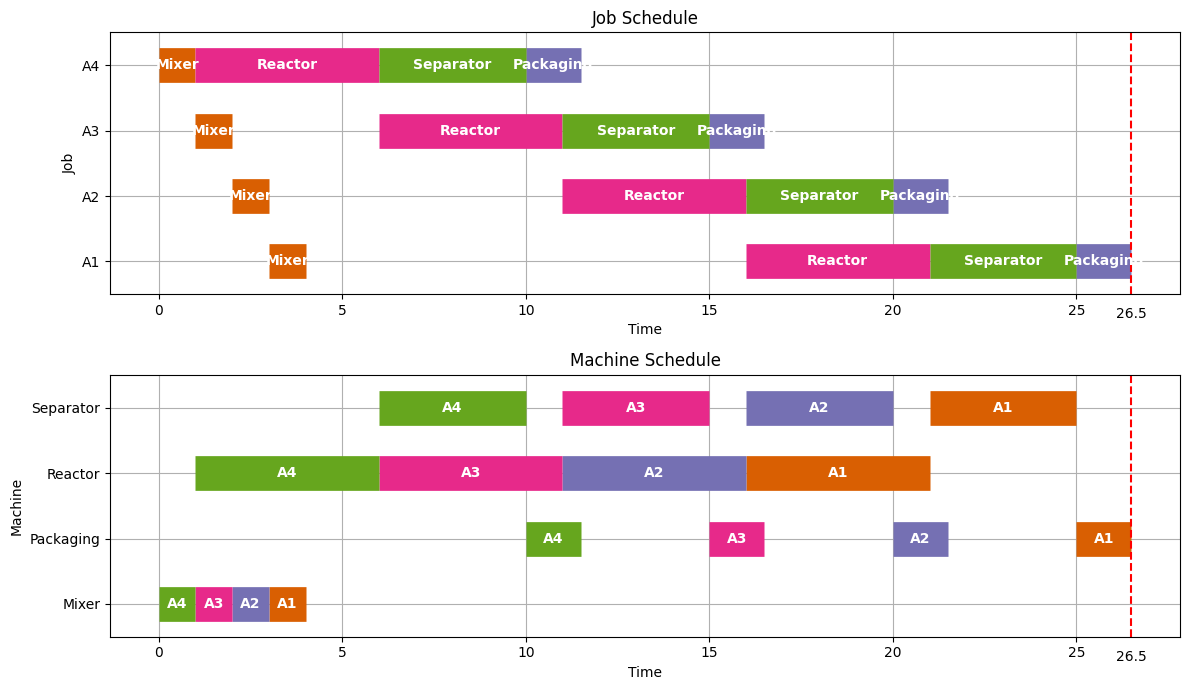

In [27]:
TASKS = recipe_to_tasks(['A1','A2','A3', 'A4'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

Earlier we found it tood 11.5 hours to produce one batch of product A.  As we see here, we can produce a second batch with only 5.0 additional hours because some of the tasks overlap.  The overlapping of tasks is the key to gaining efficiency in batch processing facilities.

Let's next consider production of a single batch each of products A, B, and C.

('A', 'Mixer') {'dur': 1, 'prec': None}
('A', 'Reactor') {'dur': 5, 'prec': ('A', 'Mixer')}
('A', 'Separator') {'dur': 4, 'prec': ('A', 'Reactor')}
('A', 'Packaging') {'dur': 1.5, 'prec': ('A', 'Separator')}
('B', 'Separator') {'dur': 4.5, 'prec': None}
('B', 'Packaging') {'dur': 1, 'prec': ('B', 'Separator')}
('C', 'Separator') {'dur': 5, 'prec': None}
('C', 'Reactor') {'dur': 3, 'prec': ('C', 'Separator')}
('C', 'Packaging') {'dur': 1.5, 'prec': ('C', 'Reactor')}
Makespan = 15.0


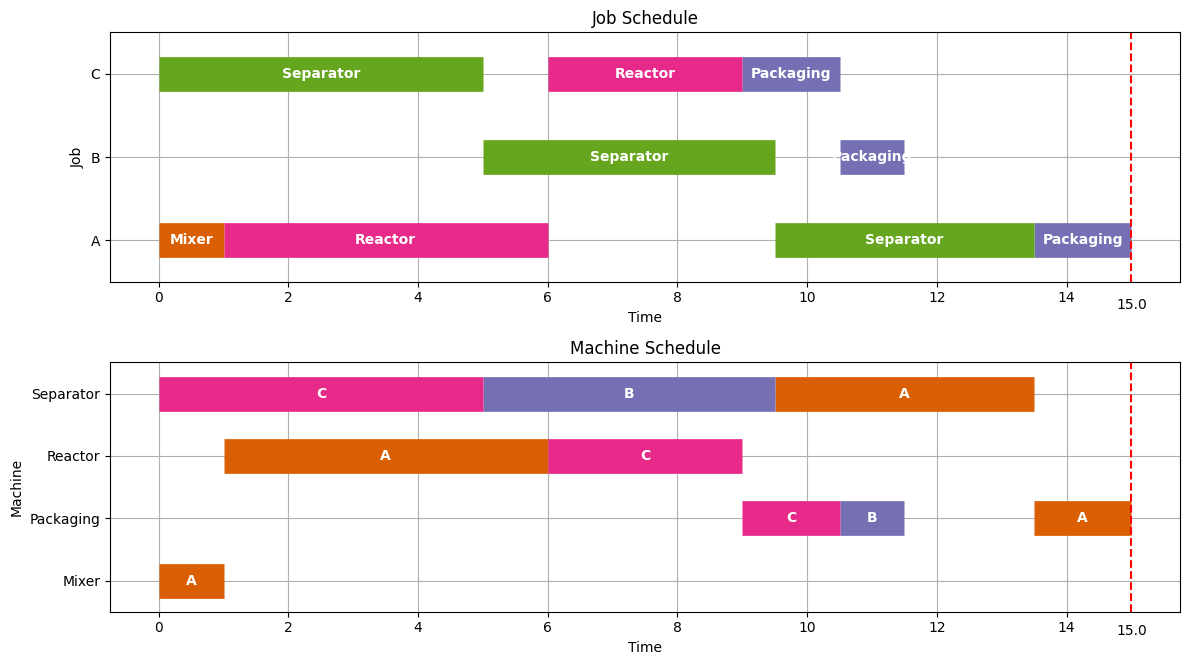

In [28]:
# update is used to append dictionaries
TASKS = recipeA
TASKS.update(recipeB)
TASKS.update(recipeC)

for k, v in TASKS.items():
    print(k, v)

results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

The individual production of A, B, and C required 11.5, 5.5, and 9.5 hours, respectively, for a total of 25.5 hours. As we see here, by scheduling the production simultaneously, we can get all three batches done in just 15 hours.

As we see below, each additional set of three products takes an additionl 13 hours.  So there is considerable efficiency gained by scheduling over longer intervals whenever possible.

Makespan = 28.0


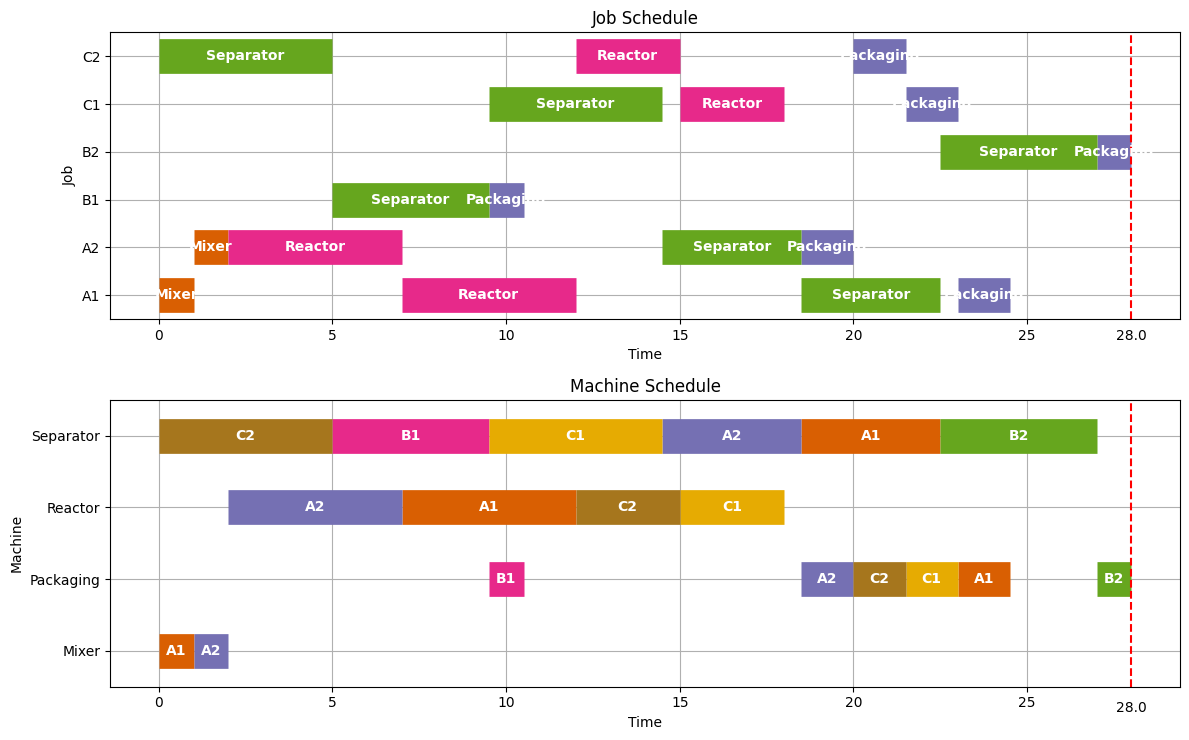

In [29]:
TASKS = recipe_to_tasks(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
TASKS.update(recipe_to_tasks(['B1','B2'],['Separator','Packaging'],[4.5,1]))
TASKS.update(recipe_to_tasks(['C1','C2'],['Separator','Reactor','Packaging'],[5,3,1.5]))

results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

### 4.3.9.3 Adding time for unit clean out

A common feature of batch unit operations is a requirement that equipment be cleaned prior to reuse.

In most cases the time needed for clean out would be specific to the equipment and product. But for the purposes this notebook, we implement can implement a simple clean out policy with a single non-negative parameter $t_{clean} \geq 0$ which, if specified, requires a period no less than $t_{clean}$ between the finish of one task and the start of another on every piece of equipment.

This policy is implemented by modifying the usual disjunctive constraints to avoid machine conflicts to read

\begin{align}
\left[\text{start}_{j,m}+\text{dur}_{j,m} + t_{clean} \leq \text{start}_{k,m}\right] \vee \left[\text{start}_{k,m}+\text{dur}_{k,m} + t_{clean} \leq \text{start}_{j,m}\right]
\end{align}

For this purpose, we write a new JobShopModel_Clean

Makespan = 30.5


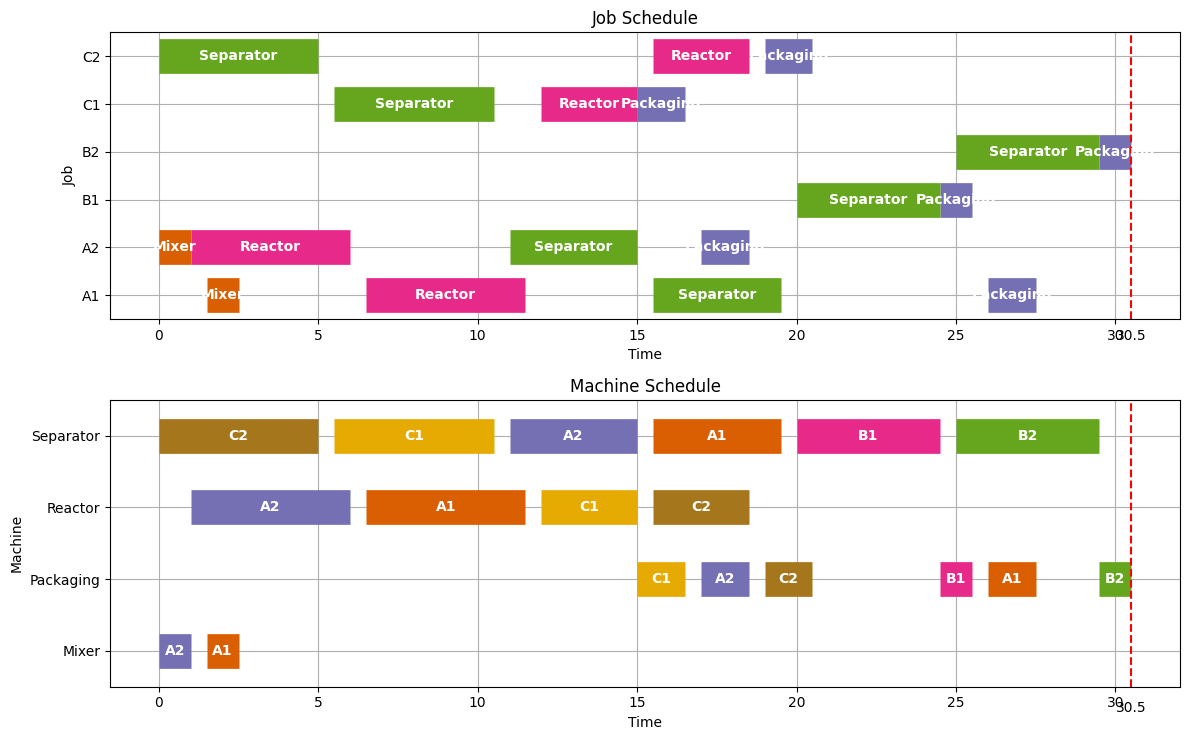

In [30]:
def jobshop_model_clean(TASKS, tclean=0):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j,m] for (j,m) in model.TASKS])

    model.makespan = Var(bounds=(0, ub))

    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
        model.start[j,m] + model.dur[j,m] <= model.makespan)

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] + tclean <= model.start[k,m],
         model.start[k,m] + model.dur[k,m] + tclean <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)
    return model

model = jobshop_model_clean(TASKS, tclean=0.5)
results = jobshop_solve(model)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

### 4.3.9.4 Adding a zero wait policy

One of the issues in the use of job shop scheduling for chemical process operations are situations where there it is not possible to store intermediate materials. If there is no way to store intermediates, either in the processing equipment or in external vessels, then a **zero-wait** policy may be required.

A zero-wait policy requires subsequent processing machines to be available immediately upon completion of any task. To implement this policy, the usual precident sequencing constraint of a job shop scheduling problem, i.e.,

\begin{align*}
\text{start}_{k,n}+\text{Dur}_{k,n} \leq \text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}
\end{align*}

is changed to

\begin{align*}
\text{start}_{k,n}+\text{Dur}_{k,n} = \text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}\text{ and ZW is True}
\end{align*}

if the zero-wait policy is in effect.

While this could be implemented on an equipment or product specific basis, here we add an optional ZW flag to the JobShop function that, by default, is set to False.

Makespan = 32.0


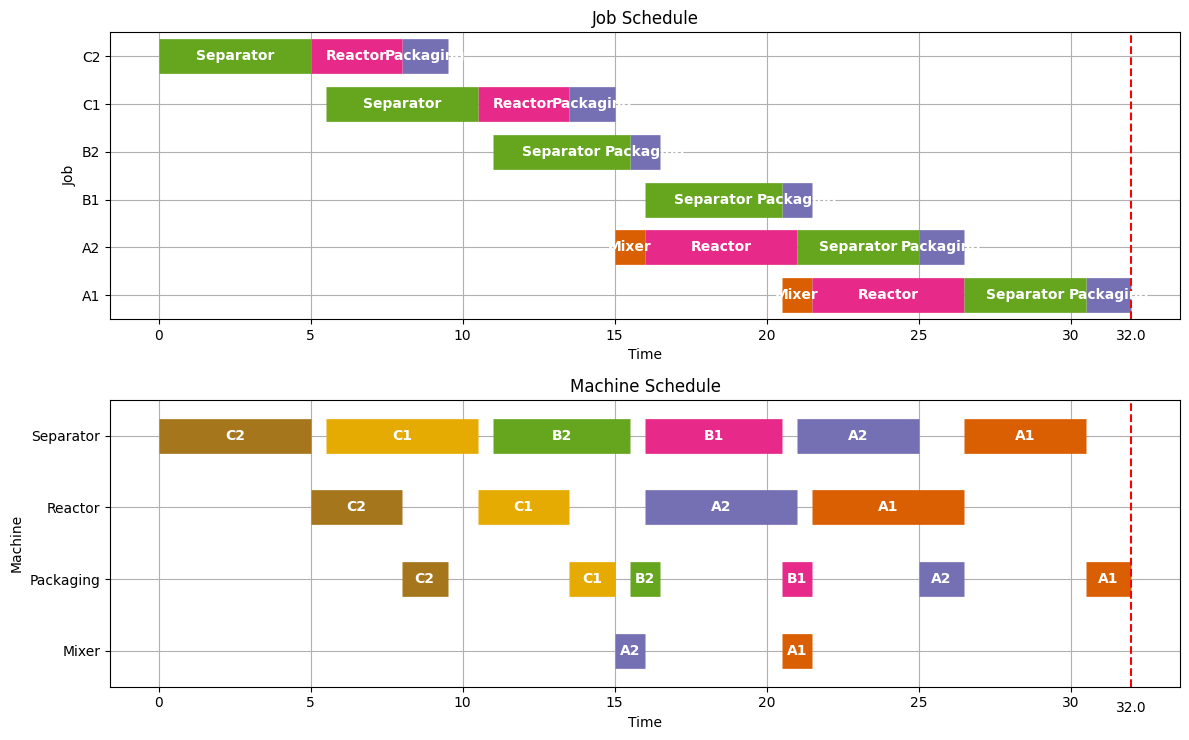

In [31]:
def jobshop_model_clean_zw(TASKS, tclean=0, ZW=False):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j,m] for (j,m) in model.TASKS])

    # to implement a zero-wait policy
    model.bigM = Param(initialize=ub if ZW else 0)

    model.makespan = Var(bounds=(0, ub))

    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
        model.start[j,m] + model.dur[j,m] <= model.makespan)

    def _preceding(model, j, m, k, n):
        if ZW:
            return  model.start[k,n] + model.dur[k,n] == model.start[j,m]
        else:
            return model.start[k,n] + model.dur[k,n] <= model.start[j,m]

    model.preceding = Constraint(model.TASKORDER, rule=_preceding)

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] + tclean <= model.start[k,m],
         model.start[k,m] + model.dur[k,m] + tclean <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)
    return model

model = jobshop_model_clean_zw(TASKS, tclean=0.5, ZW=True)
results = jobshop_solve(model)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

## 4.3.10 Solving the LA19 benchmark problem with NEOS

The file [`jobshop1.txt` contains 82 benchmark problems](http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/jobshop1.txt) from a well-known collection of job shop scheduling problems in the [OR-Library maintained by J. E. Beasley](http://people.brunel.ac.uk/~mastjjb/jeb/info.html). The data format for each example consists of a single line for each job.  The data on each line is a sequence of (machine number, time) pairs showing the order in which machines process each job.

LA19 is a benchmark problem for job shop scheduling introduced by Lawrence in 1984, and a solution presented by Cook and Applegate in 1991. The following cell may take many minutes to hours to run, depending on the choice of solver and hardware. To run, uncomment the the last lines in the cell.

In [32]:
data = """
2  44  3   5  5  58  4  97  0   9  7  84  8  77  9  96  1  58  6  89
4  15  7  31  1  87  8  57  0  77  3  85  2  81  5  39  9  73  6  21
9  82  6  22  4  10  3  70  1  49  0  40  8  34  2  48  7  80  5  71
1  91  2  17  7  62  5  75  8  47  4  11  3   7  6  72  9  35  0  55
6  71  1  90  3  75  0  64  2  94  8  15  4  12  7  67  9  20  5  50
7  70  5  93  8  77  2  29  4  58  6  93  3  68  1  57  9   7  0  52
6  87  1  63  4  26  5   6  2  82  3  27  7  56  8  48  9  36  0  95
0  36  5  15  8  41  9  78  3  76  6  84  4  30  7  76  2  36  1   8
5  88  2  81  3  13  6  82  4  54  7  13  8  29  9  40  1  78  0  75
9  88  4  54  6  64  7  32  0  52  2   6  8  54  5  82  3   6  1  26
"""

TASKS = {}
for job, line in enumerate(data.splitlines()[1:]):
    nums = line.split()
    prec = None
    for m, dur in zip(nums[::2], nums[1::2]):
        task = (f"J{job}",f"M{m}")
        TASKS[task] = {'dur':int(dur), 'prec':prec}
        prec = task

#pd.DataFrame(TASKS).T

Depending on the choice of solver, this benchmark example may require from minutes to hours of computational effort on a laptop. An alternative to solving on a laptop is to submit the job to [NEOS](https://neos-server.org/neos/), a free internet-based service for solving optimization problems hosted by the University of Wisconsin and utilizing high performance servers at locations across the globe.

The following cell shows how to solve a model using [CPLEX](https://www.ibm.com/analytics/cplex-optimizer), a high performance commericial solver, on NEOS. The solution may take several minutes, and depends on the current length of the NEOS job queue.

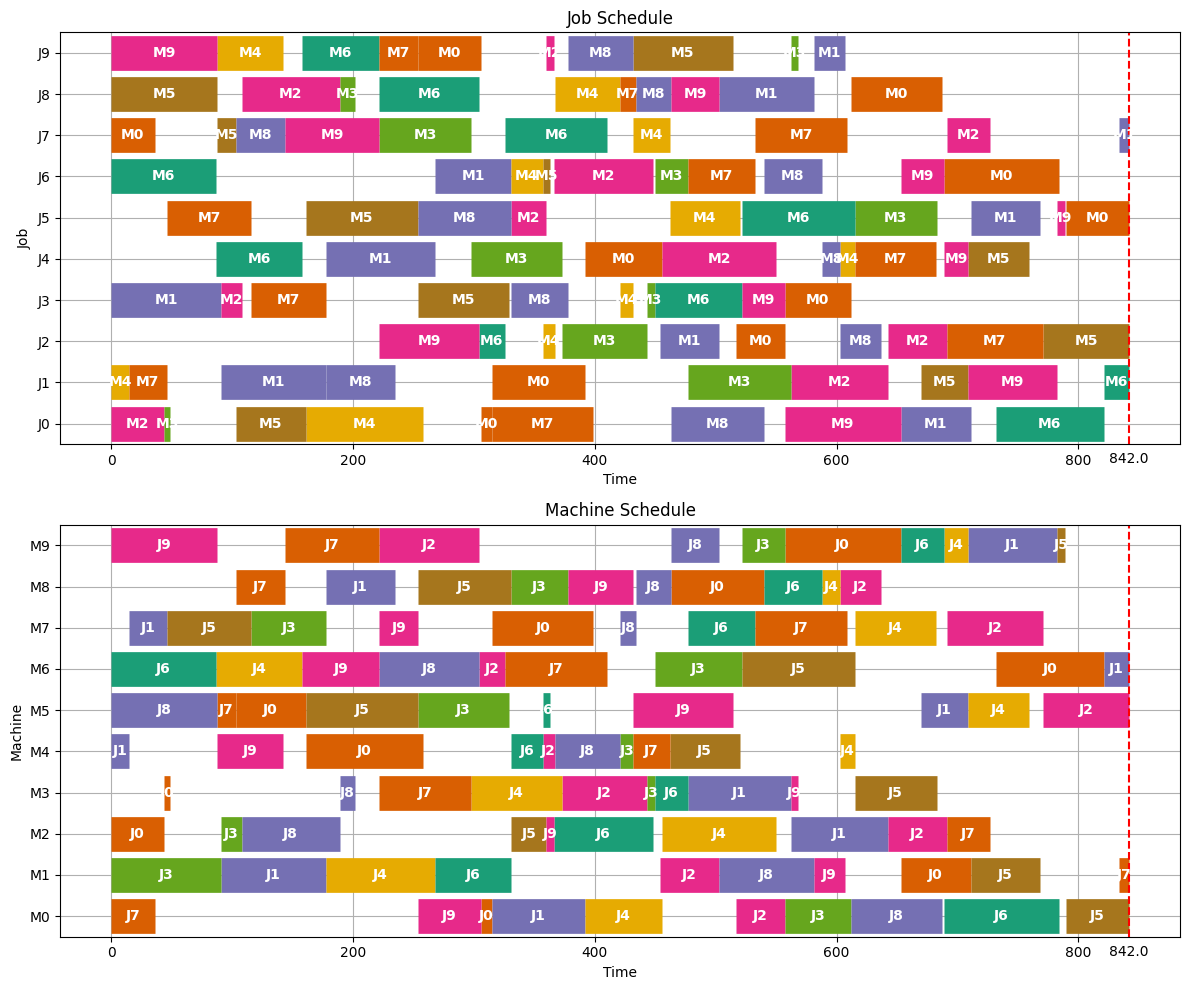

In [33]:
import os
os.environ['NEOS_EMAIL'] = 'hendrowunga8@gmail.com'

def jobshop_solve_neos(model):
    solver_manager = SolverManagerFactory('neos')
    solver_manager.solve(model, opt='cplex')
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j, m],
                'Finish': model.start[(j, m)]() + model.dur[j, m]}
               for j, m in model.TASKS]
    return results

model = jobshop_model(TASKS)
results = jobshop_solve_neos(model)
visualize(results)


## 4.3.11 References

* Applegate, David, and William Cook. ["A computational study of the job-shop scheduling problem."](https://doi.org/10.1287/ijoc.3.2.149) ORSA Journal on computing 3, no. 2 (1991): 149-156. [pdf available](http://www.math.uwaterloo.ca/~bico/papers/jobshop.pdf)
* Beasley, John E. ["OR-Library: distributing test problems by electronic mail."](https://www.jstor.org/stable/pdf/2582903.pdf?casa_token=RWUXQ6e2VngAAAAA:g-dwMXjJfCUWqoLJk5y-MpDDhLmJKSGE36YU5kpkXZ71dmos25vntN0RlDFLxDme_QsOw8Oc3oi6juXCkVCfm2gcycCK0SYNoOnOZqRYDp3EqSrXP6nDeQ) Journal of the operational research society 41, no. 11 (1990): 1069-1072. [OR-Library](http://people.brunel.ac.uk/~mastjjb/jeb/info.html)
* Guéret, Christelle, Christian Prins, and Marc Sevaux. ["Applications of optimization with Xpress-MP."](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.69.9634&rep=rep1&type=pdf) contract (1999): 00034.
* Manne, Alan S. ["On the job-shop scheduling problem."](https://doi.org/10.1287/opre.8.2.219) Operations Research 8, no. 2 (1960): 219-223.